# 8. Central Limit Theorem

**Goal:** Demonstrate universality of the Gaussian.

$$Z_n = \frac{\sum X_i - n\mu}{\sigma\sqrt{n}} \xrightarrow{d} \mathcal{N}(0,1)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

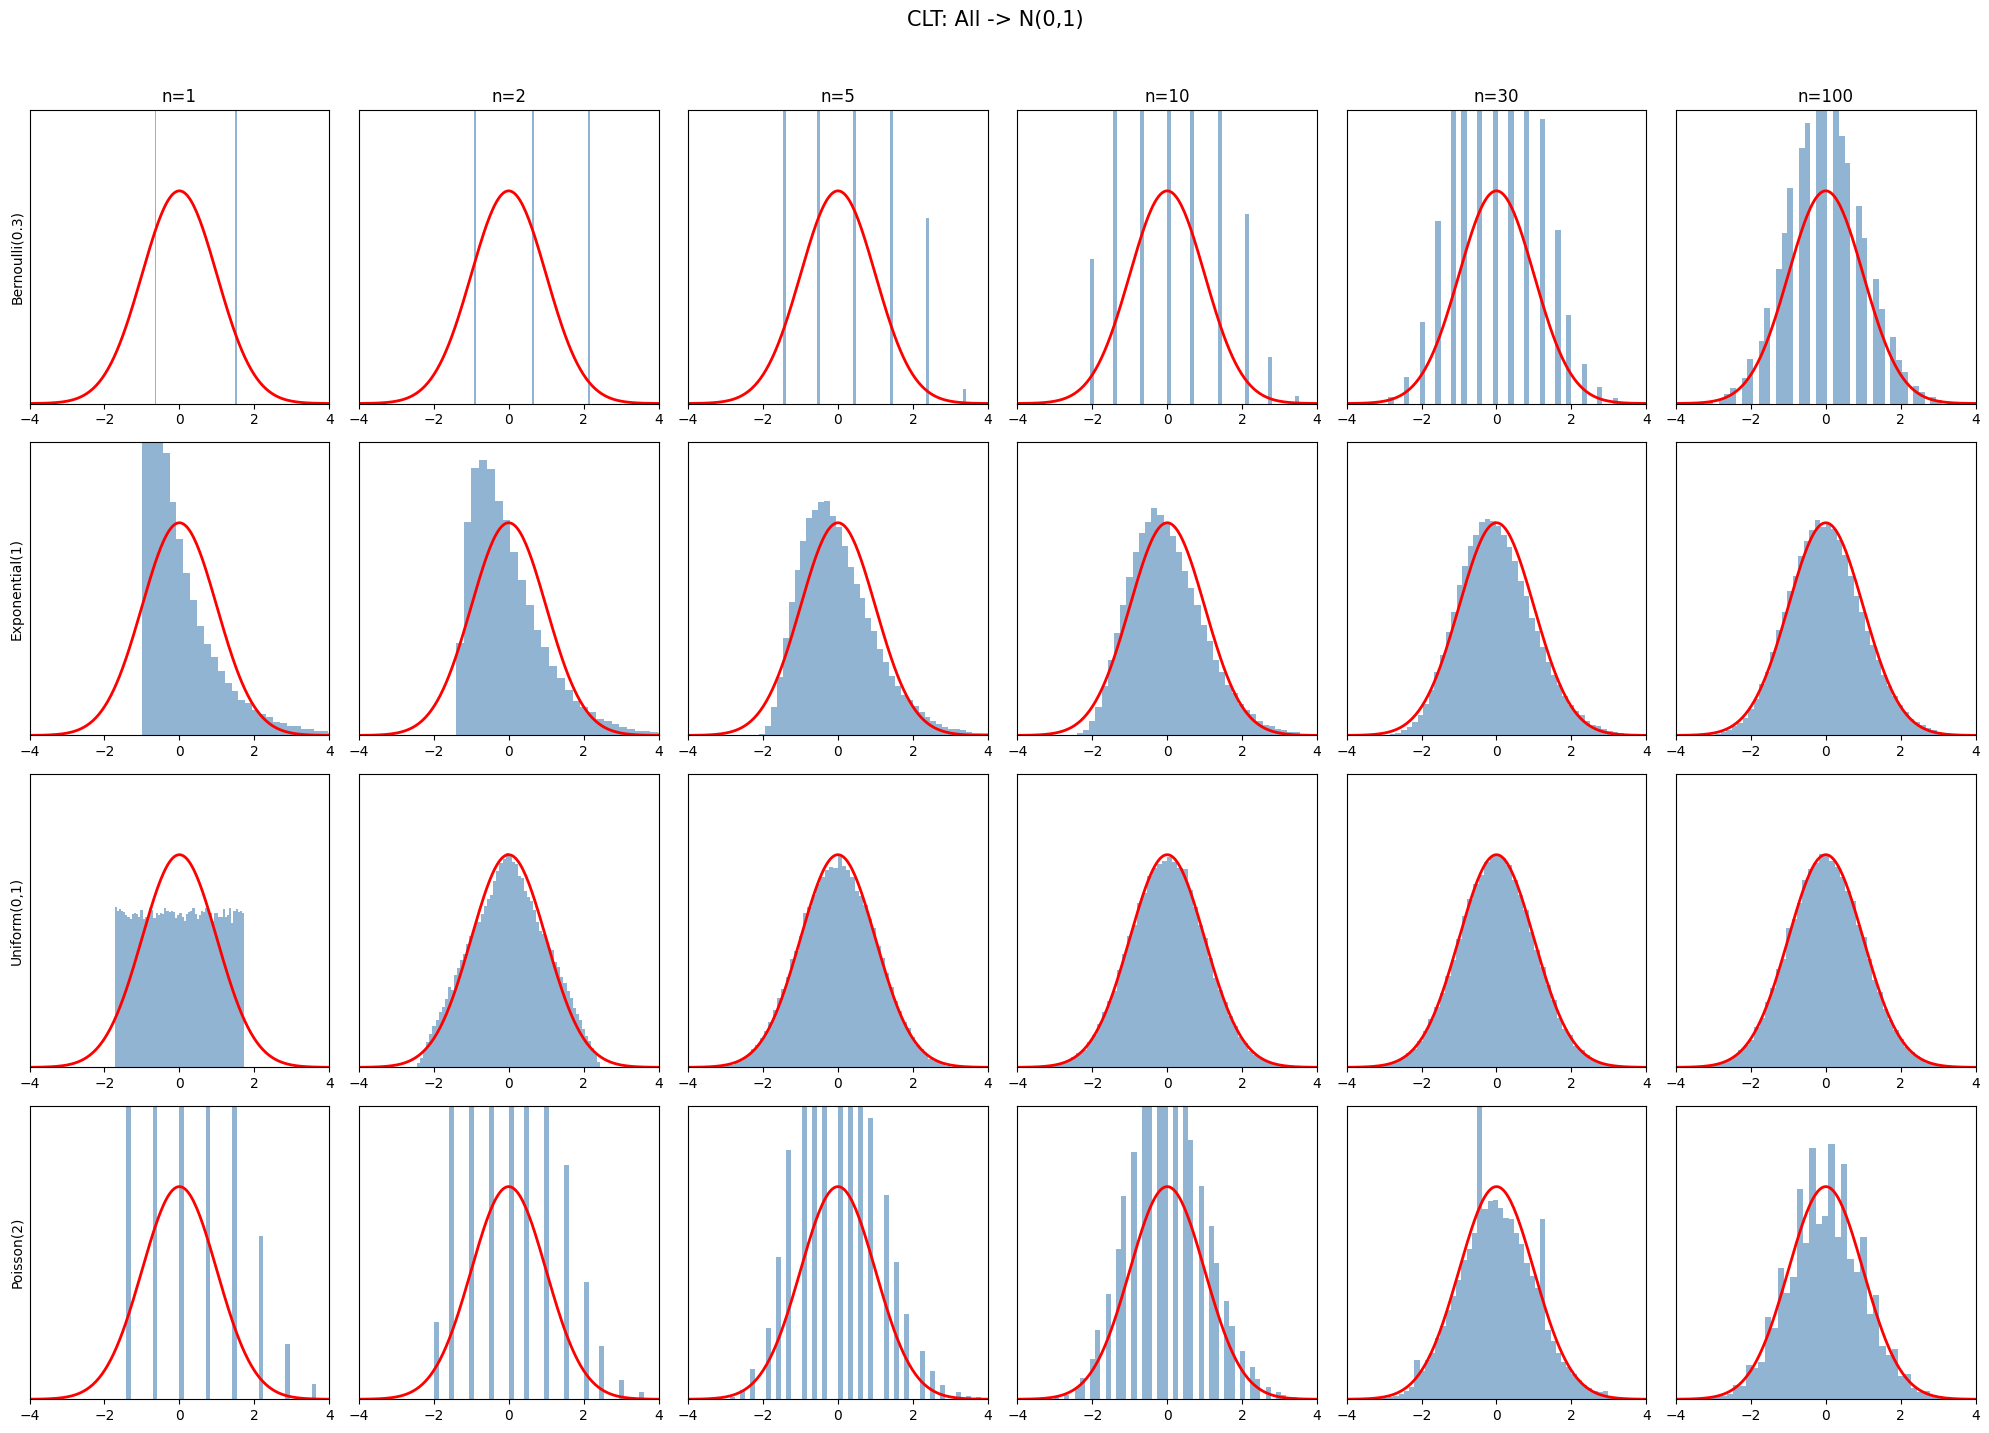

In [2]:
np.random.seed(42)
N_s = 100000
sizes = [1, 2, 5, 10, 30, 100]
dists = [
    ('Bernoulli(0.3)', lambda s: np.random.binomial(1,0.3,s), 0.3, 0.21),
    ('Exponential(1)', lambda s: np.random.exponential(1,s), 1.0, 1.0),
    ('Uniform(0,1)', lambda s: np.random.uniform(0,1,s), 0.5, 1/12),
    ('Poisson(2)', lambda s: np.random.poisson(2,s).astype(float), 2.0, 2.0),
]
fig, axes = plt.subplots(len(dists), len(sizes), figsize=(20, 3.5*len(dists)))
xg = np.linspace(-4,4,200)
for row,(name,sampler,mu,var) in enumerate(dists):
    sig = np.sqrt(var)
    for col,n in enumerate(sizes):
        ax = axes[row][col]
        Z = (np.sum(sampler((N_s,n)),axis=1) - n*mu)/(sig*np.sqrt(n))
        ax.hist(Z, bins=60, density=True, alpha=0.6, color='steelblue')
        ax.plot(xg, stats.norm.pdf(xg), 'r-', linewidth=2)
        ax.set_xlim(-4,4); ax.set_ylim(0,0.55); ax.set_yticks([])
        if row==0: ax.set_title(f'n={n}')
        if col==0: ax.set_ylabel(name)
plt.suptitle('CLT: All -> N(0,1)', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## Convergence Rate (Berry-Esseen)

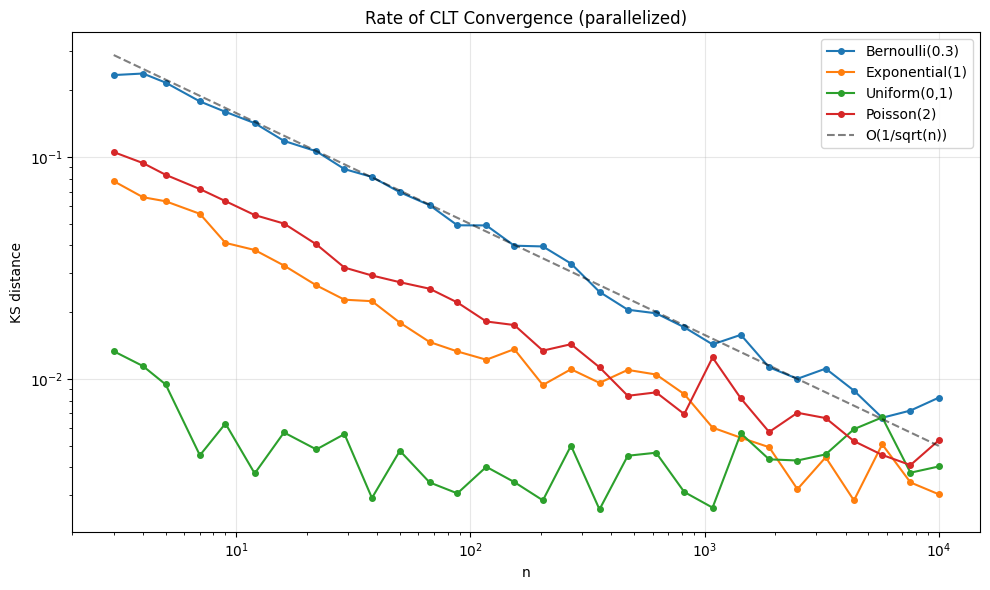

In [3]:
def ks_normal(s):
    s = np.sort(s)
    return np.max(np.abs(np.arange(1,len(s)+1)/len(s) - stats.norm.cdf(s)))

def _ks_for_dist(args):
    """Worker function: compute KS distances for one distribution across all sample sizes."""
    dist_key, mu, var, ss, n_samples, seed = args
    rng = np.random.default_rng(seed)
    samplers = {
        'bernoulli': lambda s: rng.binomial(1, 0.3, s),
        'exponential': lambda s: rng.exponential(1, s),
        'uniform': lambda s: rng.uniform(0, 1, s),
        'poisson': lambda s: rng.poisson(2, s).astype(float),
    }
    sampler = samplers[dist_key]
    sig = np.sqrt(var)
    return [ks_normal((np.sum(sampler((n_samples, n)), axis=1) - n*mu) / (sig*np.sqrt(n)))
            for n in ss]

ss = np.unique(np.logspace(0.5, 4, 30).astype(int))
dist_specs = [
    ('bernoulli',    'Bernoulli(0.3)',  0.3, 0.21),
    ('exponential',  'Exponential(1)',  1.0, 1.0),
    ('uniform',      'Uniform(0,1)',    0.5, 1/12),
    ('poisson',      'Poisson(2)',      2.0, 2.0),
]

from concurrent.futures import ThreadPoolExecutor
import os

n_workers = min(len(dist_specs), os.cpu_count() or 1)
tasks = [(key, mu, var, ss, 50000, 42 + i) for i, (key, _, mu, var) in enumerate(dist_specs)]

with ThreadPoolExecutor(max_workers=n_workers) as pool:
    results = list(pool.map(_ks_for_dist, tasks))

fig, ax = plt.subplots(figsize=(10, 6))
for (_, name, _, _), ks in zip(dist_specs, results):
    ax.plot(ss, ks, 'o-', markersize=4, label=name)
ax.plot(ss, 0.5/np.sqrt(ss), 'k--', alpha=0.5, label='O(1/sqrt(n))')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('n'); ax.set_ylabel('KS distance')
ax.set_title('Rate of CLT Convergence (parallelized)'); ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## CLT Fails: Cauchy

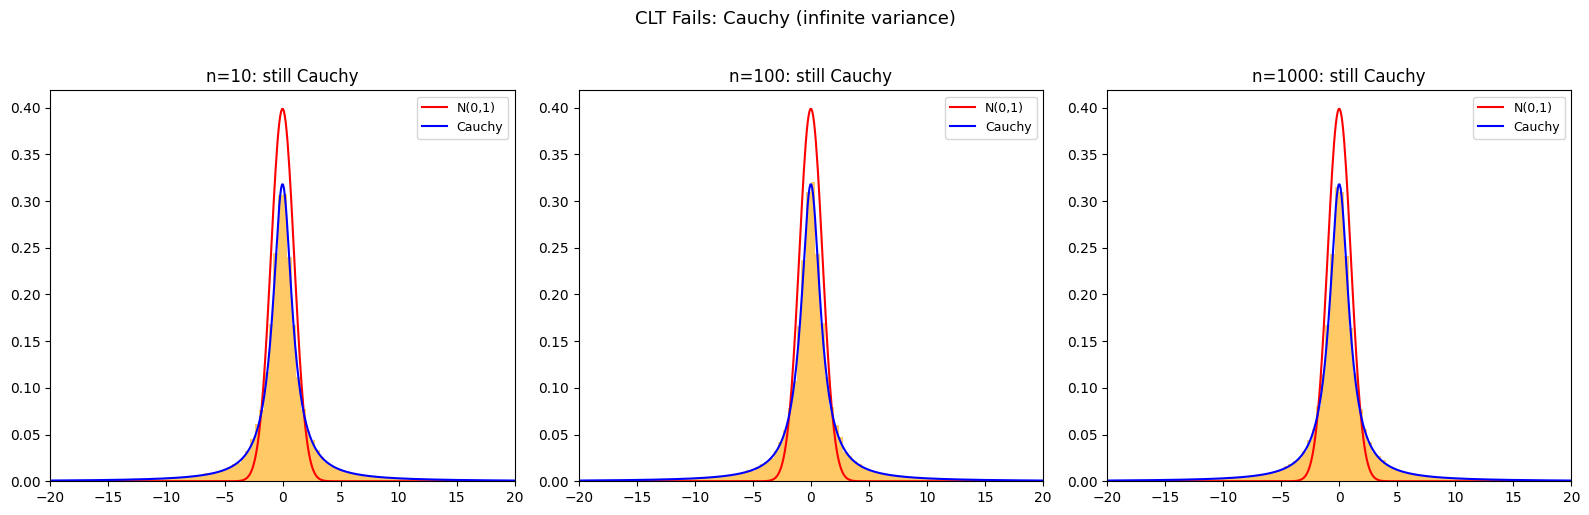

In [4]:
np.random.seed(42)
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for col,n in enumerate([10,100,1000]):
    ax = axes[col]
    Z = np.mean(np.random.standard_cauchy((50000,n)), axis=1)
    Zc = Z[(Z>-20)&(Z<20)]
    ax.hist(Zc, bins=100, density=True, alpha=0.6, color='orange')
    xg = np.linspace(-20,20,500)
    ax.plot(xg, stats.norm.pdf(xg), 'r-', label='N(0,1)')
    ax.plot(xg, stats.cauchy.pdf(xg), 'b-', label='Cauchy')
    ax.set_title(f'n={n}: still Cauchy'); ax.set_xlim(-20,20); ax.legend(fontsize=9)
plt.suptitle('CLT Fails: Cauchy (infinite variance)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Universality:** works for any finite-variance distribution.
2. **Rate:** $O(1/\sqrt{n})$ (Berry-Esseen).
3. **Finite variance essential:** Cauchy sums stay Cauchy.
4. Explains ubiquity of the normal distribution.